In [1]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 100
device = torch.device("cpu")

eps = 0.1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))



def actual_soln(eps):
    return ((x)**2)*((1 - y)**2)*((1 - x)**2)*((y)**2)

In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return  out
	
def lag_coeffs(num):
		lis = [np.array([1]),np.array([1,-1])]
		for n in range(1,num-1):
			xl1 = np.concatenate((np.array([0]),lis[n]),axis = 0)
			l1 = np.concatenate((lis[n],np.array([0])),axis = 0)		
			l0 = np.concatenate((lis[n-1],np.array([0,0])),axis = 0)
			l = ((2*n + 1)*l1 - xl1 - n*l0)/(n + 1)
			lis.append(l)
		for n in range(num):
			lis[n] = np.concatenate((lis[n],np.array([0]*(num-1-n))),axis = 0)
		return lis

def poly(coeffs,x):
	sum = torch.zeros_like(x)
	for i,coeff in enumerate(coeffs):
		sum = sum + coeff*(x**i)
	return sum

class Lag_FBPINN(nn.Module):
	def __init__(self,basis_num):
		super(Lag_FBPINN,self).__init__()
		self.tanh = nn.Tanh()
		self.basis_num = basis_num
		self.main = nn.Sequential(
			#nn.Linear(2*basis_num,2*basis_num),
			nn.Linear(2*basis_num,1))		
	def forward(self,input):
		tanh1 = self.tanh(input)
		tanh2 = self.tanh(1 - input)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		coeffs = lag_coeffs(self.basis_num)
		x = input[:,0]
		t = input[:,1]
		netin = torch.Tensor([])
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],x.view(-1,1))),1)
		for i in range(self.basis_num):
			netin = torch.cat((netin,poly(coeffs[i],t.view(-1,1))),1)
		netout = self.main(netin)
		return netout*tanh11*tanh22

In [4]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size):
	
	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
		
	net = FBPINN()# Lag_PINN(10)#FBPINN()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = ((xnet)**2)*((1 - ynet)**2)*((1 - xnet)**2)*((ynet)**2)

		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.10f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses 

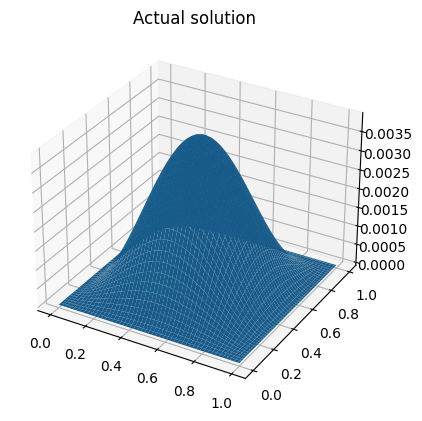

In [6]:
plot_graph(actual_soln(eps),'Actual solution')

78
Train Epoch: 0 	Loss: 0.0074251452
Train Epoch: 0 	Loss: 0.0004908050
Train Epoch: 0 	Loss: 0.0001254081
Train Epoch: 0 	Loss: 0.0000697166

After Epoch 0, 	 Actual solution loss: 0.0000000056



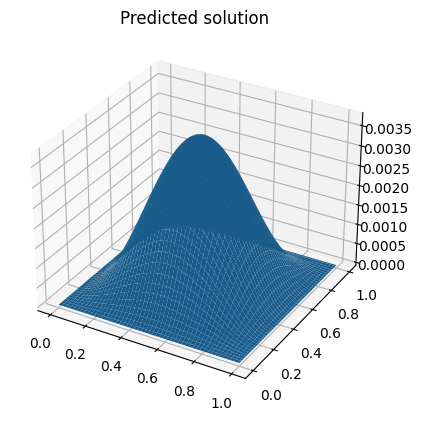

Train Epoch: 1 	Loss: 0.0000314328
Train Epoch: 1 	Loss: 0.0000120078
Train Epoch: 1 	Loss: 0.0000085435
Train Epoch: 1 	Loss: 0.0000076408

After Epoch 1, 	 Actual solution loss: 0.0000000012



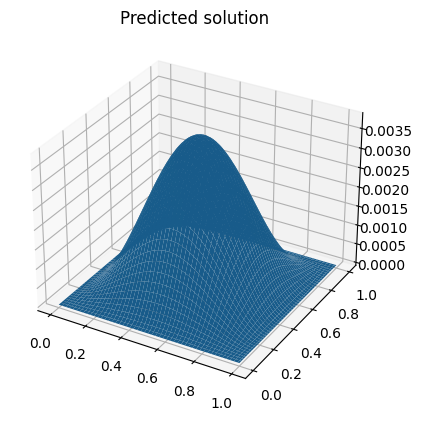

Train Epoch: 2 	Loss: 0.0000052185
Train Epoch: 2 	Loss: 0.0000050364
Train Epoch: 2 	Loss: 0.0000036531
Train Epoch: 2 	Loss: 0.0000029842

After Epoch 2, 	 Actual solution loss: 0.0000000004



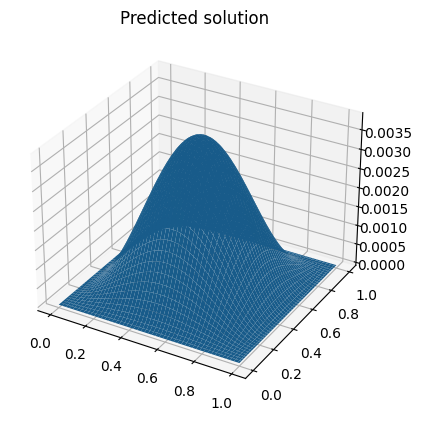

Train Epoch: 3 	Loss: 0.0000023586
Train Epoch: 3 	Loss: 0.0000015650
Train Epoch: 3 	Loss: 0.0000016301
Train Epoch: 3 	Loss: 0.0000010116

After Epoch 3, 	 Actual solution loss: 0.0000000001



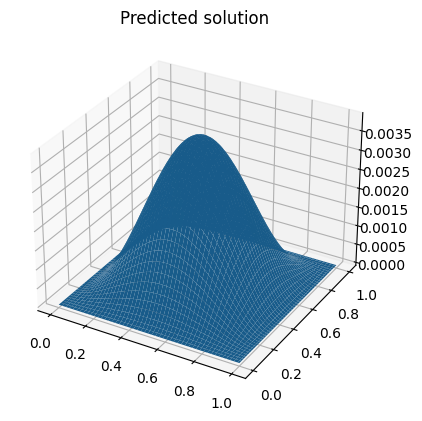

Train Epoch: 4 	Loss: 0.0000010636
Train Epoch: 4 	Loss: 0.0000008212
Train Epoch: 4 	Loss: 0.0000008724
Train Epoch: 4 	Loss: 0.0000006487

After Epoch 4, 	 Actual solution loss: 0.0000000000



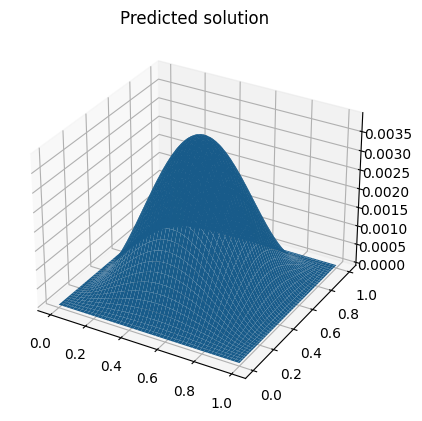

Train Epoch: 5 	Loss: 0.0000004936
Train Epoch: 5 	Loss: 0.0000004667
Train Epoch: 5 	Loss: 0.0000003751
Train Epoch: 5 	Loss: 0.0000002463

After Epoch 5, 	 Actual solution loss: 0.0000000000



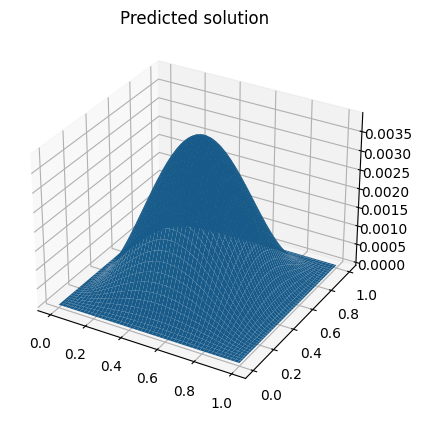

Train Epoch: 6 	Loss: 0.0000002095
Train Epoch: 6 	Loss: 0.0000002487
Train Epoch: 6 	Loss: 0.0000002052
Train Epoch: 6 	Loss: 0.0000002297

After Epoch 6, 	 Actual solution loss: 0.0000000000



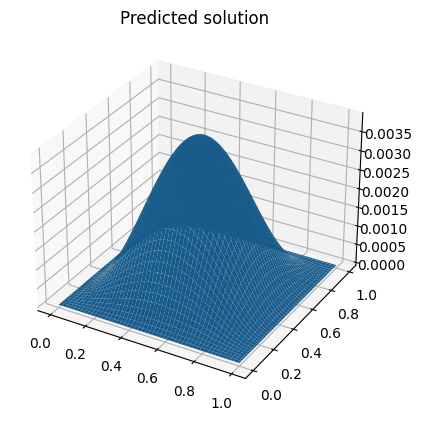

Train Epoch: 7 	Loss: 0.0000001732
Train Epoch: 7 	Loss: 0.0000001935
Train Epoch: 7 	Loss: 0.0000003539
Train Epoch: 7 	Loss: 0.0000001336

After Epoch 7, 	 Actual solution loss: 0.0000000000



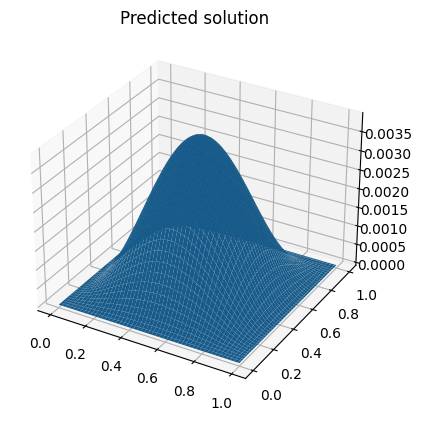

Train Epoch: 8 	Loss: 0.0000001278
Train Epoch: 8 	Loss: 0.0000005112
Train Epoch: 8 	Loss: 0.0000003367
Train Epoch: 8 	Loss: 0.0000001010

After Epoch 8, 	 Actual solution loss: 0.0000000002



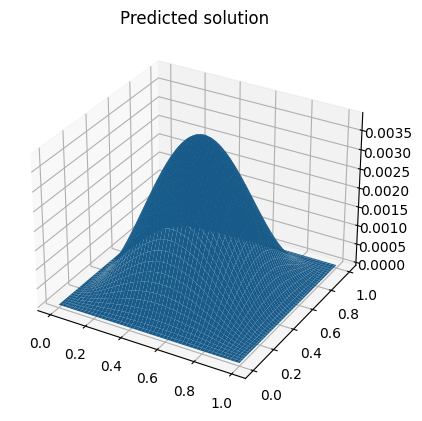

Train Epoch: 9 	Loss: 0.0000006703
Train Epoch: 9 	Loss: 0.0000009667
Train Epoch: 9 	Loss: 0.0000005221
Train Epoch: 9 	Loss: 0.0000004260

After Epoch 9, 	 Actual solution loss: 0.0000000000



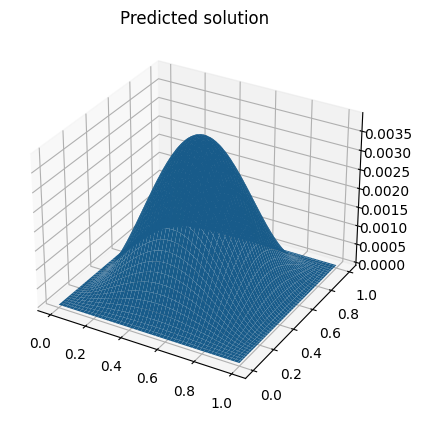

Train Epoch: 10 	Loss: 0.0000001131
Train Epoch: 10 	Loss: 0.0000000679
Train Epoch: 10 	Loss: 0.0000000945
Train Epoch: 10 	Loss: 0.0000000691

After Epoch 10, 	 Actual solution loss: 0.0000000000



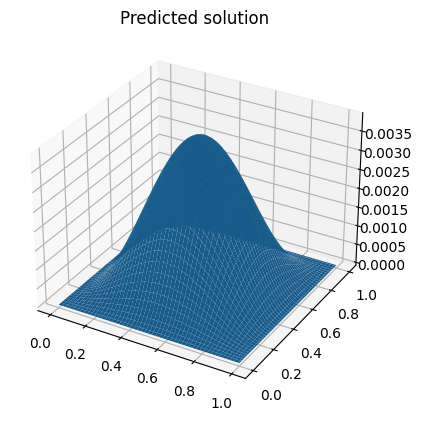

Train Epoch: 11 	Loss: 0.0000001496
Train Epoch: 11 	Loss: 0.0000001875
Train Epoch: 11 	Loss: 0.0000029318
Train Epoch: 11 	Loss: 0.0000002155

After Epoch 11, 	 Actual solution loss: 0.0000000004



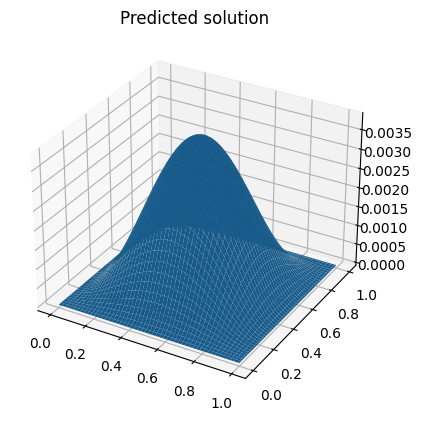

Train Epoch: 12 	Loss: 0.0000016419
Train Epoch: 12 	Loss: 0.0000008596
Train Epoch: 12 	Loss: 0.0000005052
Train Epoch: 12 	Loss: 0.0000002043

After Epoch 12, 	 Actual solution loss: 0.0000000000



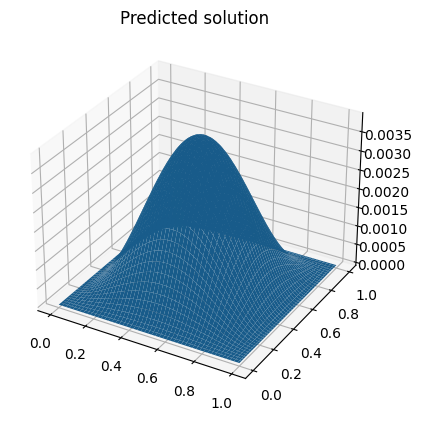

Train Epoch: 13 	Loss: 0.0000000618
Train Epoch: 13 	Loss: 0.0000000830
Train Epoch: 13 	Loss: 0.0000000794
Train Epoch: 13 	Loss: 0.0000001582

After Epoch 13, 	 Actual solution loss: 0.0000000000



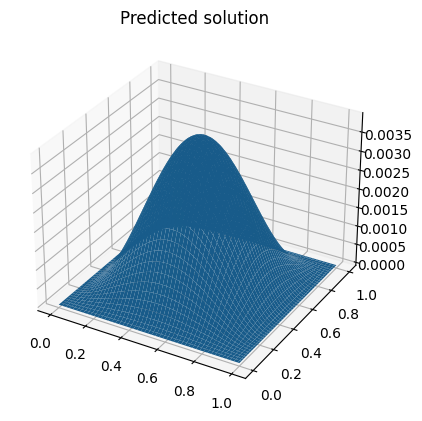

Train Epoch: 14 	Loss: 0.0000001458
Train Epoch: 14 	Loss: 0.0000002265
Train Epoch: 14 	Loss: 0.0000000416
Train Epoch: 14 	Loss: 0.0000000417

After Epoch 14, 	 Actual solution loss: 0.0000000001



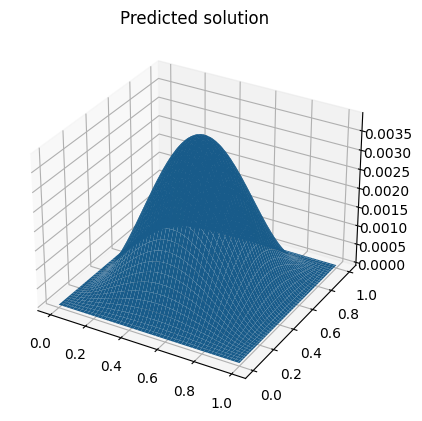

Train Epoch: 15 	Loss: 0.0000002358
Train Epoch: 15 	Loss: 0.0000006467
Train Epoch: 15 	Loss: 0.0000021869
Train Epoch: 15 	Loss: 0.0000002230

After Epoch 15, 	 Actual solution loss: 0.0000000002



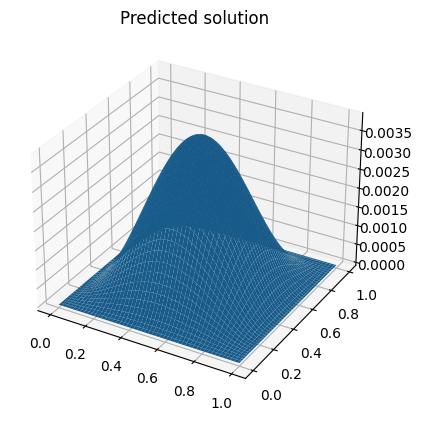

Train Epoch: 16 	Loss: 0.0000004718
Train Epoch: 16 	Loss: 0.0000001092
Train Epoch: 16 	Loss: 0.0000000470
Train Epoch: 16 	Loss: 0.0000001337

After Epoch 16, 	 Actual solution loss: 0.0000000000



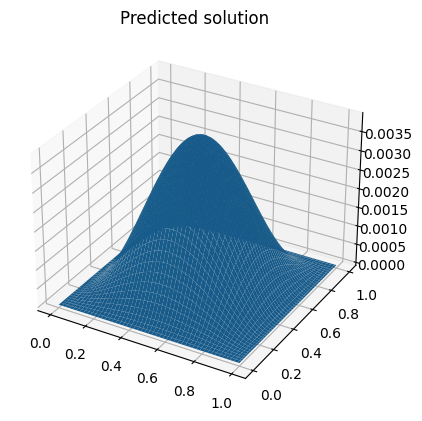

Train Epoch: 17 	Loss: 0.0000000354
Train Epoch: 17 	Loss: 0.0000001433
Train Epoch: 17 	Loss: 0.0000000583
Train Epoch: 17 	Loss: 0.0000004726

After Epoch 17, 	 Actual solution loss: 0.0000000001



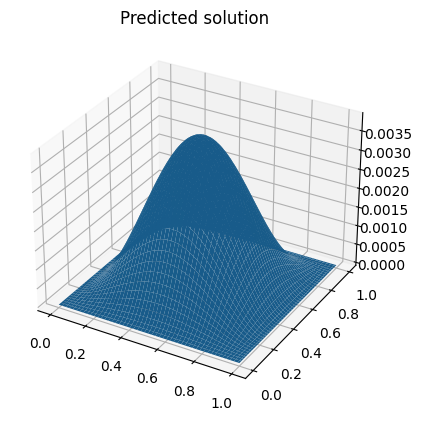

Train Epoch: 18 	Loss: 0.0000003820
Train Epoch: 18 	Loss: 0.0000001201
Train Epoch: 18 	Loss: 0.0000000726
Train Epoch: 18 	Loss: 0.0000000777

After Epoch 18, 	 Actual solution loss: 0.0000000000



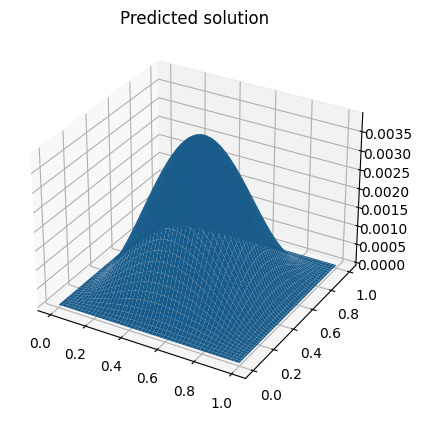

Train Epoch: 19 	Loss: 0.0000000515
Train Epoch: 19 	Loss: 0.0000000613
Train Epoch: 19 	Loss: 0.0000003342
Train Epoch: 19 	Loss: 0.0000005698

After Epoch 19, 	 Actual solution loss: 0.0000000000



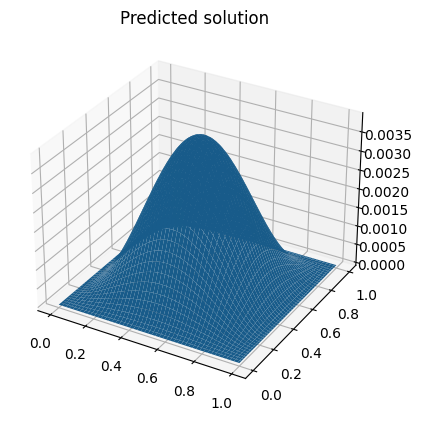

Train Epoch: 20 	Loss: 0.0000001074
Train Epoch: 20 	Loss: 0.0000000867
Train Epoch: 20 	Loss: 0.0000000424
Train Epoch: 20 	Loss: 0.0000000315

After Epoch 20, 	 Actual solution loss: 0.0000000000



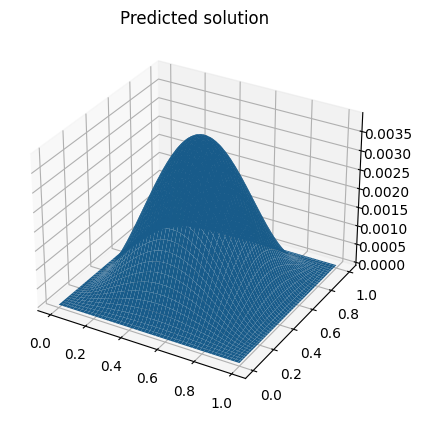

Train Epoch: 21 	Loss: 0.0000000131
Train Epoch: 21 	Loss: 0.0000000299
Train Epoch: 21 	Loss: 0.0000000695
Train Epoch: 21 	Loss: 0.0000003278

After Epoch 21, 	 Actual solution loss: 0.0000000000



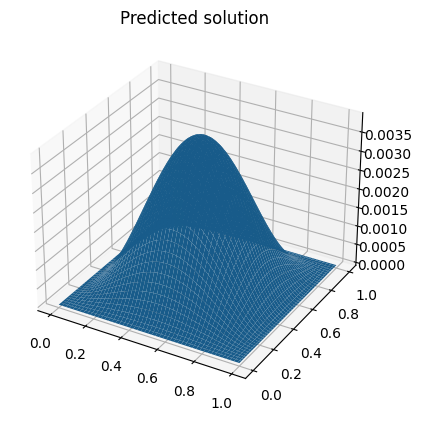

Train Epoch: 22 	Loss: 0.0000003774
Train Epoch: 22 	Loss: 0.0000000363
Train Epoch: 22 	Loss: 0.0000000134
Train Epoch: 22 	Loss: 0.0000000502

After Epoch 22, 	 Actual solution loss: 0.0000000000



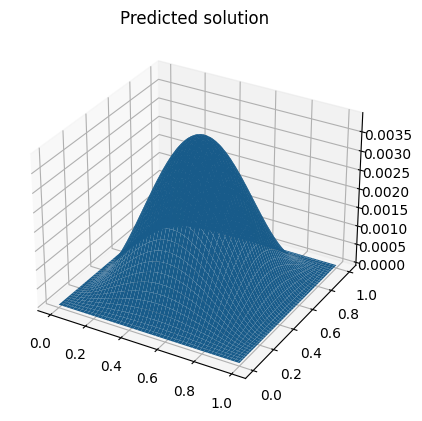

Train Epoch: 23 	Loss: 0.0000000446
Train Epoch: 23 	Loss: 0.0000000551
Train Epoch: 23 	Loss: 0.0000001638
Train Epoch: 23 	Loss: 0.0000001088

After Epoch 23, 	 Actual solution loss: 0.0000000000



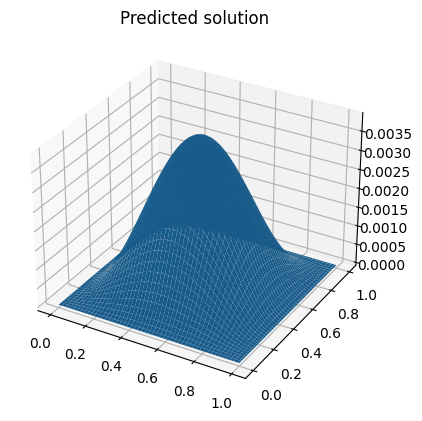

Train Epoch: 24 	Loss: 0.0000001279
Train Epoch: 24 	Loss: 0.0000001249
Train Epoch: 24 	Loss: 0.0000001788
Train Epoch: 24 	Loss: 0.0000000200

After Epoch 24, 	 Actual solution loss: 0.0000000000



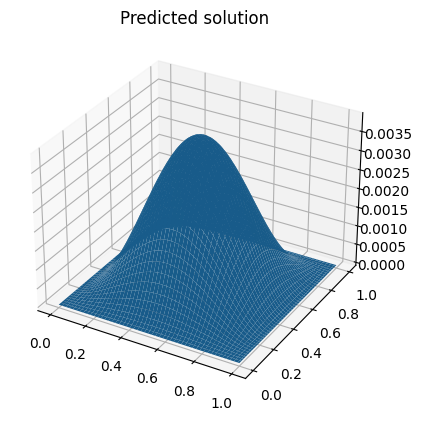

Train Epoch: 25 	Loss: 0.0000000176
Train Epoch: 25 	Loss: 0.0000003738
Train Epoch: 25 	Loss: 0.0000003281
Train Epoch: 25 	Loss: 0.0000001021

After Epoch 25, 	 Actual solution loss: 0.0000000001



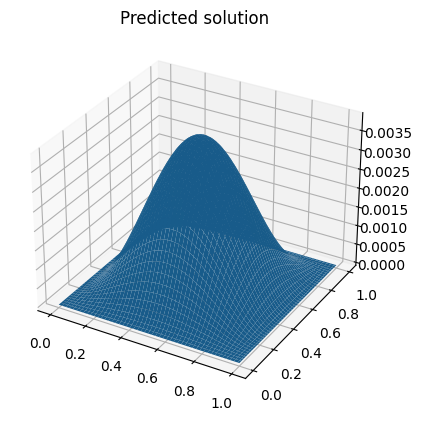

Train Epoch: 26 	Loss: 0.0000003165
Train Epoch: 26 	Loss: 0.0000001634
Train Epoch: 26 	Loss: 0.0000000757
Train Epoch: 26 	Loss: 0.0000000266

After Epoch 26, 	 Actual solution loss: 0.0000000000



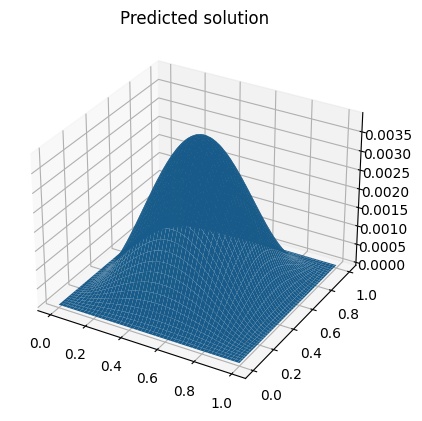

Train Epoch: 27 	Loss: 0.0000000626
Train Epoch: 27 	Loss: 0.0000000395
Train Epoch: 27 	Loss: 0.0000001770
Train Epoch: 27 	Loss: 0.0000000799

After Epoch 27, 	 Actual solution loss: 0.0000000000



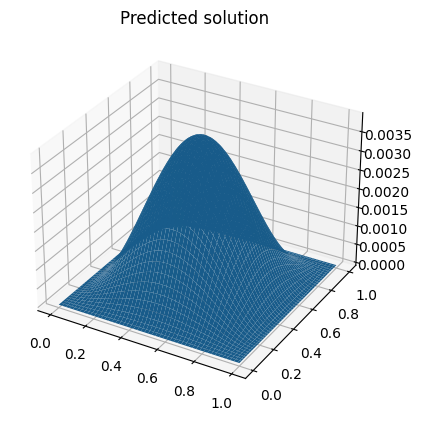

Train Epoch: 28 	Loss: 0.0000000395
Train Epoch: 28 	Loss: 0.0000001184
Train Epoch: 28 	Loss: 0.0000002251
Train Epoch: 28 	Loss: 0.0000000803

After Epoch 28, 	 Actual solution loss: 0.0000000000



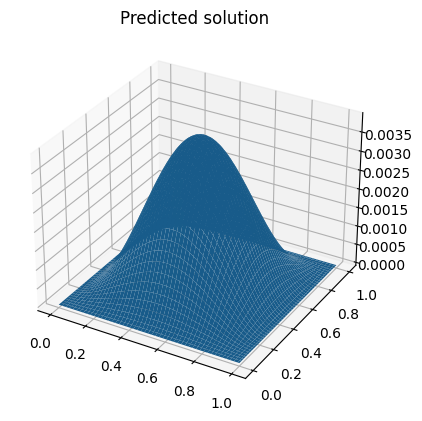

Train Epoch: 29 	Loss: 0.0000000780
Train Epoch: 29 	Loss: 0.0000000144
Train Epoch: 29 	Loss: 0.0000000059
Train Epoch: 29 	Loss: 0.0000000106

After Epoch 29, 	 Actual solution loss: 0.0000000000



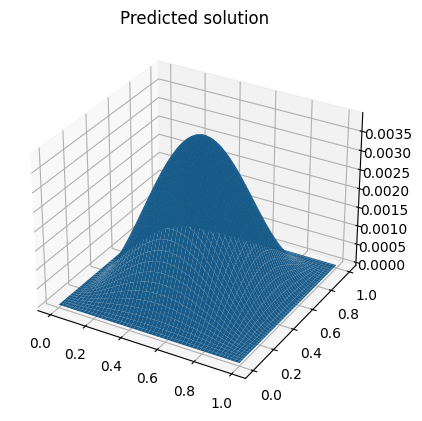

Train Epoch: 30 	Loss: 0.0000000923
Train Epoch: 30 	Loss: 0.0000000061
Train Epoch: 30 	Loss: 0.0000000053
Train Epoch: 30 	Loss: 0.0000000038

After Epoch 30, 	 Actual solution loss: 0.0000000000



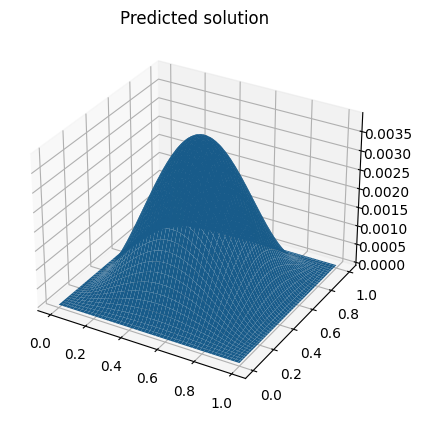

Train Epoch: 31 	Loss: 0.0000000043
Train Epoch: 31 	Loss: 0.0000000048
Train Epoch: 31 	Loss: 0.0000000049
Train Epoch: 31 	Loss: 0.0000000040

After Epoch 31, 	 Actual solution loss: 0.0000000000



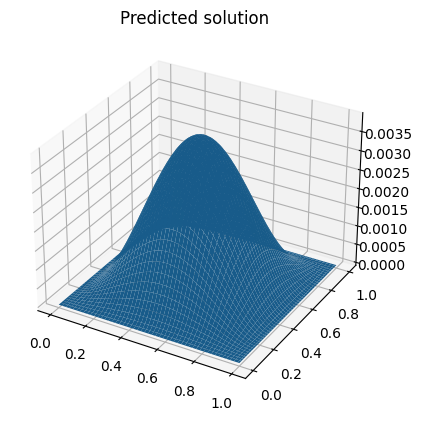

Train Epoch: 32 	Loss: 0.0000000033
Train Epoch: 32 	Loss: 0.0000000048
Train Epoch: 32 	Loss: 0.0000000047
Train Epoch: 32 	Loss: 0.0000000035

After Epoch 32, 	 Actual solution loss: 0.0000000000



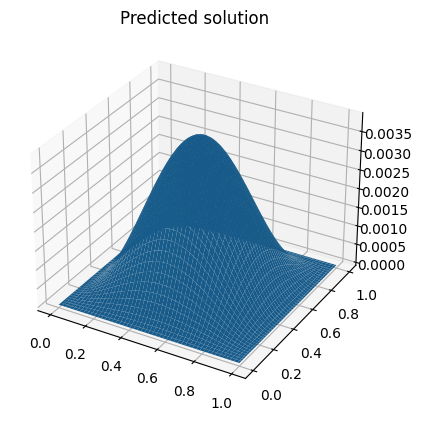

Train Epoch: 33 	Loss: 0.0000000038
Train Epoch: 33 	Loss: 0.0000000045
Train Epoch: 33 	Loss: 0.0000000040
Train Epoch: 33 	Loss: 0.0000000052

After Epoch 33, 	 Actual solution loss: 0.0000000000



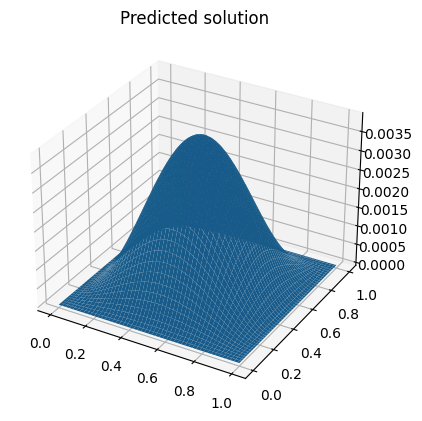

Train Epoch: 34 	Loss: 0.0000000047
Train Epoch: 34 	Loss: 0.0000000046
Train Epoch: 34 	Loss: 0.0000000035
Train Epoch: 34 	Loss: 0.0000000044

After Epoch 34, 	 Actual solution loss: 0.0000000000



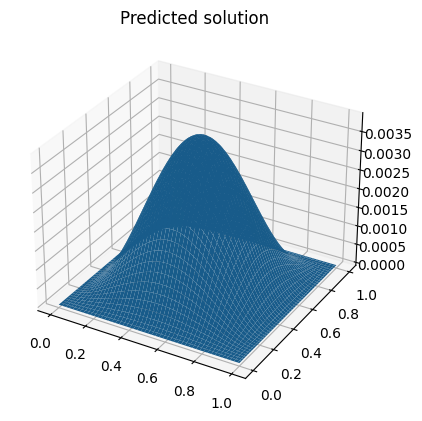

Train Epoch: 35 	Loss: 0.0000000041
Train Epoch: 35 	Loss: 0.0000000054
Train Epoch: 35 	Loss: 0.0000000040
Train Epoch: 35 	Loss: 0.0000000043

After Epoch 35, 	 Actual solution loss: 0.0000000000



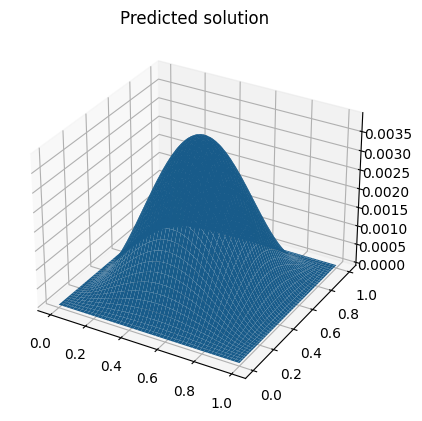

Train Epoch: 36 	Loss: 0.0000000056
Train Epoch: 36 	Loss: 0.0000000046
Train Epoch: 36 	Loss: 0.0000000052
Train Epoch: 36 	Loss: 0.0000000043

After Epoch 36, 	 Actual solution loss: 0.0000000000



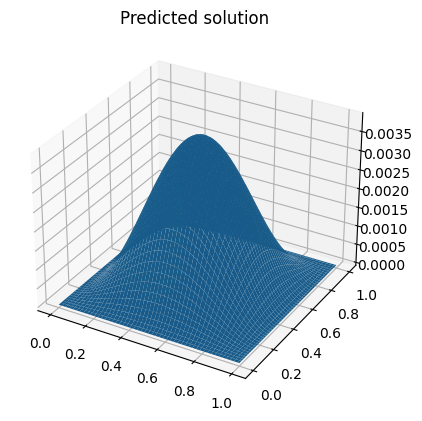

Train Epoch: 37 	Loss: 0.0000000063
Train Epoch: 37 	Loss: 0.0000000046
Train Epoch: 37 	Loss: 0.0000000049
Train Epoch: 37 	Loss: 0.0000000049

After Epoch 37, 	 Actual solution loss: 0.0000000000



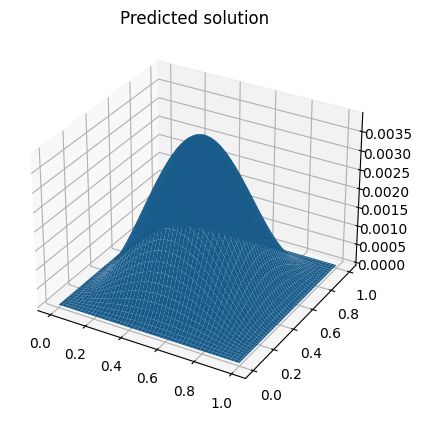

: 

In [7]:
output,losses = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize)

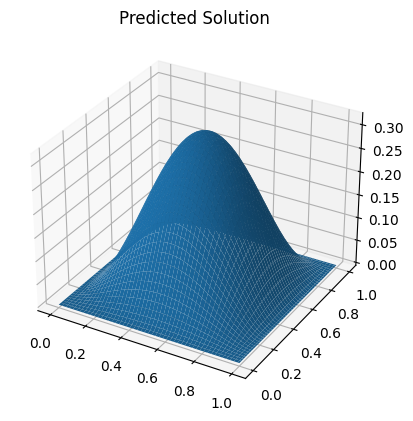

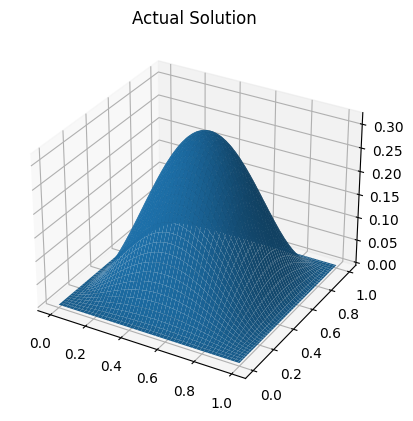

In [ ]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

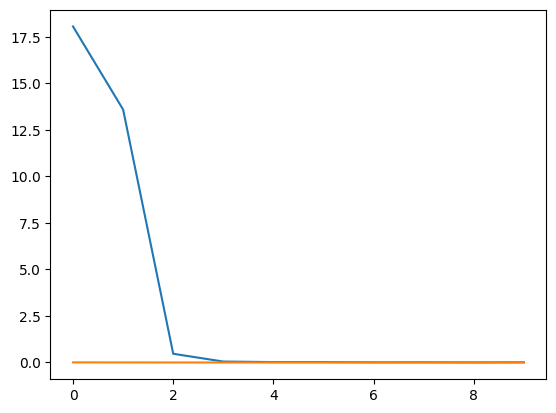

In [ ]:
plt.plot(losses)
plt.show()

In [11]:
import torch

# Create a 1D tensor
x = torch.tensor([1, 2, 3])

# Unsqueeze to add a new dimension (convert to a 2D tensor)
y = x.unsqueeze(0)

print(x)
print(y)

tensor([1, 2, 3])
tensor([[1, 2, 3]])
